## Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Libraries & Loading the Data

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import nltk
import re
from langdetect import detect
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from multiprocessing import Pool, cpu_count
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.decomposition import LatentDirichletAllocation
# Modelling
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
# Model Evaluation
from sklearn.metrics import precision_recall_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

# Ensure NLTK libraries are downloaded (only once)
nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")

# For the postings.csv file
# job_data = pd.read_csv('/content/drive/MyDrive/265 group project/Dataset/postings.csv', on_bad_lines='skip')
job_data = pd.read_csv('/content/drive/MyDrive/MSBA_265_Final_Project/data/postings.csv', on_bad_lines='skip')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## EDA

In [ ]:
# sampling
sample_size = int(0.05 * len(job_data))  # 5% of data
job_data = job_data.sample(n=sample_size, random_state=42)

In [ ]:
# Check the first few rows of the job dataset
job_data.head()

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
73989,3902944011,Current Power,Senior Automation Engineer - Power Systems,The Senior Automation / Power Systems Engineer...,NaN,NaN,"Houston, TX",760913.0,22.0,NaN,...,NaN,1.713280e+12,NaN,0,FULL_TIME,NaN,NaN,NaN,77002.0,48201.0
59308,3901960222,DISH Network,DISH Installation Technician - Field,"Company Summary\n\nDISH, an EchoStar Company, ...",19.75,HOURLY,"Orange, TX",4296.0,5.0,NaN,...,NaN,1.713478e+12,jobs.dish.com,0,FULL_TIME,USD,BASE_SALARY,41080.0,77630.0,48361.0
44663,3900944095,"Coca-Cola Bottling Company UNITED, Inc.",Order Builder,Division: North Alabama\n\nDepartment : Oxford...,NaN,NaN,"Oxford, AL",136791.0,4.0,NaN,...,NaN,1.713389e+12,careers.cokeonena.com,0,FULL_TIME,NaN,NaN,NaN,36203.0,1015.0
81954,3903878594,Denver7 (KMGH-TV),"Mountain Multimedia Journalist, KMGH","KMGH, the E.W. Scripps Company ABC affiliate i...",NaN,NaN,"Denver, CO",11500365.0,4.0,NaN,...,NaN,1.713496e+12,scripps.wd5.myworkdayjobs.com,0,FULL_TIME,NaN,NaN,NaN,80202.0,8031.0
113151,3905670593,BAYADA Home Health Care,Licensed Practical Nurse (LPN),"Come for the Flexibility, Stay for the Culture...",35.00,HOURLY,"Teterboro, NJ",19472.0,4.0,NaN,...,NaN,1.713521e+12,jsv3.recruitics.com,0,FULL_TIME,USD,BASE_SALARY,67600.0,7608.0,34003.0


In [ ]:
job_data.shape

(6192, 31)

In [ ]:
# Check the data structure and columns
job_data.info()
job_data.columns

<class 'pandas.core.frame.DataFrame'>
Index: 6192 entries, 73989 to 27022
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   job_id                      6192 non-null   int64  
 1   company_name                6110 non-null   object 
 2   title                       6192 non-null   object 
 3   description                 6192 non-null   object 
 4   max_salary                  1483 non-null   float64
 5   pay_period                  1794 non-null   object 
 6   location                    6192 non-null   object 
 7   company_id                  6110 non-null   float64
 8   views                       6103 non-null   float64
 9   med_salary                  311 non-null    float64
 10  min_salary                  1483 non-null   float64
 11  formatted_work_type         6192 non-null   object 
 12  applies                     1147 non-null   float64
 13  original_listed_time        6192 

Index(['job_id', 'company_name', 'title', 'description', 'max_salary',
       'pay_period', 'location', 'company_id', 'views', 'med_salary',
       'min_salary', 'formatted_work_type', 'applies', 'original_listed_time',
       'remote_allowed', 'job_posting_url', 'application_url',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'skills_desc', 'listed_time',
       'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'normalized_salary', 'zip_code', 'fips'],
      dtype='object')

In [ ]:
# Check for missing values

job_data.isnull().sum()

,0
job_id,0
company_name,82
title,0
description,0
max_salary,4709
pay_period,4398
location,0
company_id,82
views,89
med_salary,5881


In [ ]:
# Basic statistics on numerical columns
job_data.describe()

,job_id,max_salary,company_id,views,med_salary,min_salary,applies,original_listed_time,remote_allowed,expiry,closed_time,listed_time,sponsored,normalized_salary,zip_code,fips
count,6.192000e+03,1483.000000,6.110000e+03,6103.000000,311.000000,1483.000000,1147.000000,6.192000e+03,752.0,6.192000e+03,5.600000e+01,6.192000e+03,6192.0,1.794000e+03,5151.000000,4812.000000
mean,3.895435e+09,87441.660283,1.243762e+07,14.745043,20098.386270,61066.809885,10.986051,1.713142e+12,1.0,1.716212e+12,1.712905e+12,1.713193e+12,0.0,1.323087e+05,50182.648612,28602.243350
std,9.848751e+07,90033.440172,2.595054e+07,92.169031,44070.938314,59054.545587,32.226426,4.842108e+08,0.0,2.349382e+09,3.734538e+08,4.046670e+08,0.0,1.531328e+06,30113.394906,15967.295033
min,9.217160e+05,12.800000,1.009000e+03,1.000000,10.000000,1.000000,1.000000,1.706306e+12,1.0,1.712954e+12,1.712356e+12,1.712346e+12,0.0,2.200000e+01,1013.000000,1003.000000
25%,3.894546e+09,50.000000,1.406400e+04,3.000000,18.500000,40.000000,1.000000,1.712861e+12,1.0,1.715478e+12,1.712670e+12,1.712870e+12,0.0,5.200000e+04,24690.000000,13105.500000
50%,3.901984e+09,82149.600000,2.047700e+05,4.000000,26.000000,60000.000000,3.000000,1.713393e+12,1.0,1.716001e+12,1.712670e+12,1.713403e+12,0.0,8.320000e+04,47620.000000,29183.000000
75%,3.904586e+09,140000.000000,7.513150e+06,8.000000,100.000000,100000.000000,8.000000,1.713478e+12,1.0,1.716087e+12,1.713282e+12,1.713483e+12,0.0,1.250000e+05,78201.000000,42049.000000
max,3.906265e+09,831891.000000,1.034588e+08,6105.000000,225000.000000,350000.000000,508.000000,1.713572e+12,1.0,1.729124e+12,1.713557e+12,1.713573e+12,0.0,6.489600e+07,99901.000000,56041.000000


In [ ]:
# Look at the distribution of job titles and descriptions
job_data['title'].value_counts()

,count
title,
Sales Manager,44
Project Manager,26
Administrative Assistant,17
Receptionist,16
Registered Nurse,16
...,...
Waitstaff Mariposa Restaurant 37.5 Hrs,1
Senior EVS Director,1
"Area Leisure Sales Manager, Hawaii",1


In [ ]:
# Fill missing values (if necessary)
job_data['description'].fillna('', inplace=True)
job_data['skills_desc'].fillna('', inplace=True)
job_data['remote_allowed'].fillna('No', inplace=True)

In [ ]:
# Create new features
job_data['job_length'] = job_data['description'].apply(len)
job_data['remote_flag'] = job_data['remote_allowed'].apply(lambda x: 1 if x == 'Yes' else 0)

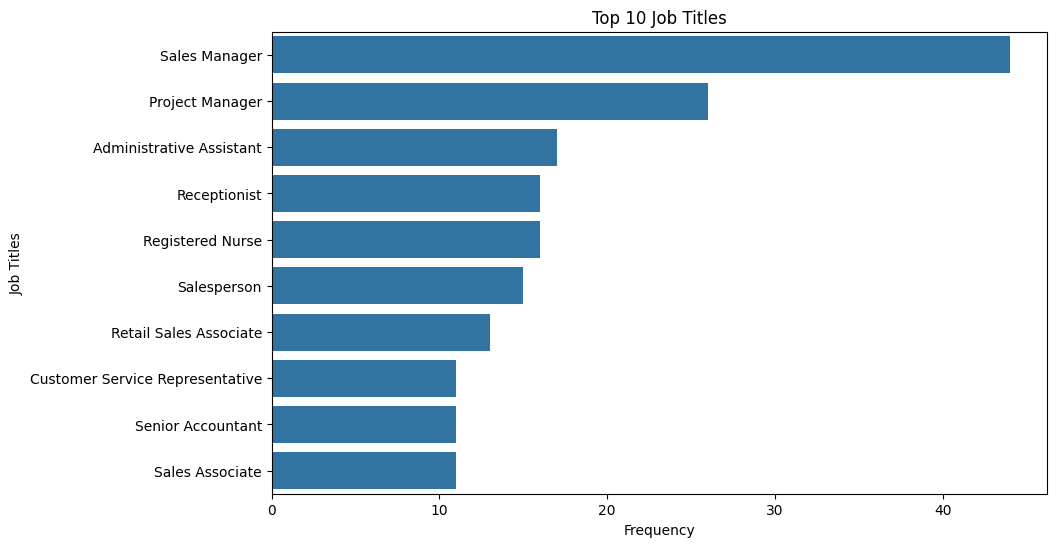

In [ ]:
# Job Title Distribution
plt.figure(figsize=(10, 6))
sns.countplot(y=job_data['title'], order=job_data['title'].value_counts().index[:10])  # Show top 10 job titles
plt.title('Top 10 Job Titles')
plt.xlabel('Frequency')
plt.ylabel('Job Titles')
plt.show()

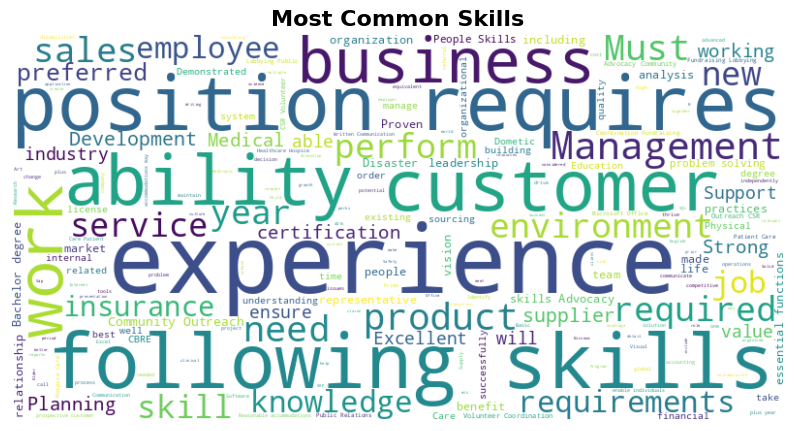

In [ ]:
# Word Cloud of Skills
skills_text = ' '.join(job_data['skills_desc'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(skills_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Skills', fontsize=16, fontweight='bold')
plt.show()

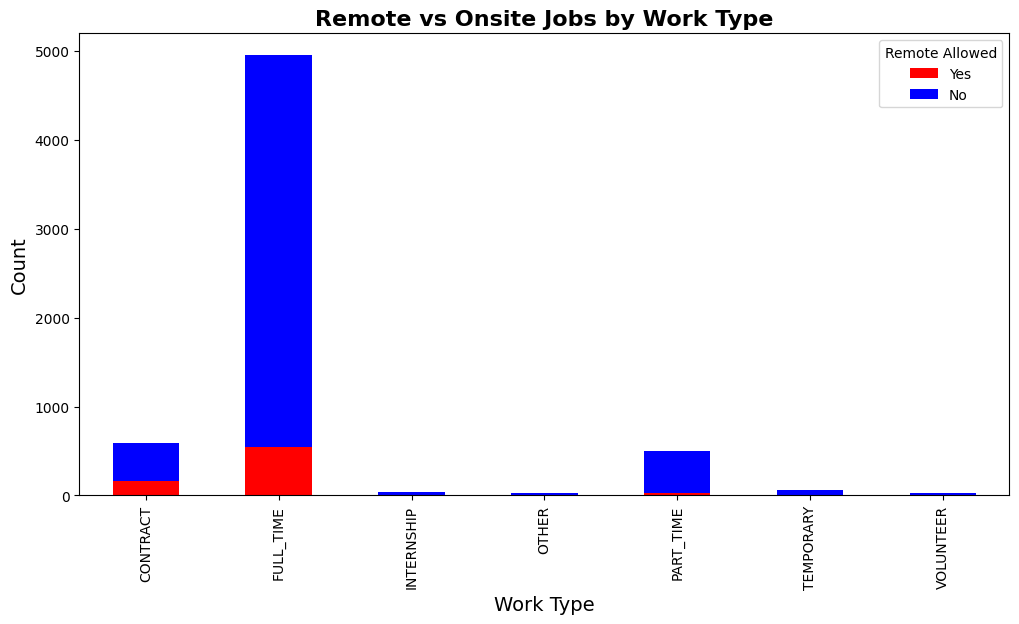

In [ ]:
# Remote vs Onsite Jobs
# Replace numerical remote values with labels 'Yes' and 'No' for better readability
job_data['remote_allowed'] = job_data['remote_allowed'].replace({1.0: 'Yes', 0.0: 'No'})

# Group data for the plot
remote_vs_onsite = job_data.groupby(['work_type', 'remote_allowed']).size().unstack(fill_value=0)

# Ensure the column order matches "Yes" and "No" for correct color mapping
remote_vs_onsite = remote_vs_onsite[['Yes', 'No']]

# Define colors: red for "Yes", blue for "No"
colors = ['red', 'blue']

# Plotting
remote_vs_onsite.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
plt.title('Remote vs Onsite Jobs by Work Type', fontsize=16, fontweight='bold')
plt.xlabel('Work Type', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(title='Remote Allowed', labels=['Yes', 'No'])
plt.show()


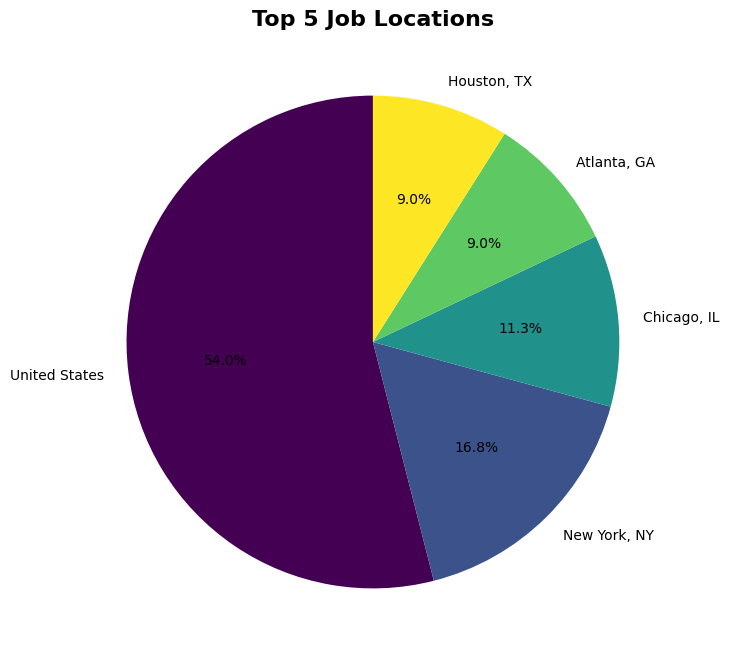

In [ ]:
# Top Job Locations
top_locations = job_data['location'].value_counts().head(5)
top_locations.plot.pie(autopct='%1.1f%%', figsize=(8, 8), startangle=90, cmap='viridis')
plt.title('Top 5 Job Locations', fontsize=16, fontweight='bold')
plt.ylabel('')
plt.show()

In [ ]:
# Top Skills Distribution
all_skills = job_data['skills_desc'].dropna().str.split(',').sum()
top_skills = pd.Series(Counter(all_skills)).sort_values(ascending=False).head(10)

# Extract top required skills as features (binary features for top skills)
top_skills = top_skills.index.tolist()
for skill in top_skills:
    job_data[f'skill_{skill}'] = job_data['skills_desc'].apply(lambda x: 1 if skill in str(x) else 0)

# Check feature engineering results
job_data[['job_length', 'remote_flag'] + [f'skill_{skill}' for skill in top_skills]].head()


,job_length,remote_flag,skill_,skill_ Fundraising,skill_ Community Outreach,skill_This position requires the following skills: Advocacy,skill_ CSR / Volunteer Coordination,skill_ Lobbying,skill_ Public Relations,skill_ People Skills,skill_ Patient Care,skill_ Hospice Care
73989,4610,0,1,0,0,0,0,0,0,0,0,0
59308,3042,0,1,0,0,0,0,0,0,0,0,0
44663,3295,0,1,0,0,0,0,0,0,0,0,0
81954,5478,0,1,0,0,0,0,0,0,0,0,0
113151,2030,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
!pip install langdetect
!pip install nltk

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# Define custom stopwords
custom_stopwords = set(stopwords.words('english') + ['experience', 'required', 'skills', 'job', 'work'])

# Function for efficient language detection (regex-based pre-check + langdetect fallback)
def language_check(text):
    # Use a quick regex-based check for common English words
    if bool(re.search(r'\b(english|software|project|data|skills|management|work)\b', text, re.IGNORECASE)):
        return True
    # Fallback to langdetect for uncertain cases
    try:
        return detect(text) == 'en'
    except:
        return False

# Advanced text cleaning function
def advanced_text_cleaning(text):
    # Skip very short descriptions
    if len(text) < 50:
        return 'short_description'

    # Handle contractions (using regex)
    contractions = {
        "I'm": "I am", "you're": "you are", "he's": "he is", "she's": "she is",
        "it's": "it is", "we're": "we are", "they're": "they are", "can't": "cannot",
        "won't": "will not", "n't": " not", "'re": " are", "'ll": " will", "'ve": " have", "'s": " is"
    }
    text = re.sub(r'\b(?:{})\b'.format('|'.join(map(re.escape, contractions.keys()))),
                  lambda match: contractions[match.group(0)], text)

    # Perform language detection
    if not language_check(text):
        return 'non_english_description'

    # Tokenize and remove stopwords
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in custom_stopwords]

    return ' '.join(tokens)

# Function to process data in parallel
def process_in_parallel(df, column='description', chunk_size=1000):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' not found in the dataframe.")

    num_chunks = len(df) // chunk_size + (1 if len(df) % chunk_size != 0 else 0)
    with Pool(cpu_count()) as pool:
        results = pool.map(process_chunk, [df.iloc[i*chunk_size:(i+1)*chunk_size] for i in range(num_chunks)])
    return pd.concat(results)

# Helper function to process a chunk
def process_chunk(chunk):
    chunk['description_cleaned'] = chunk['description'].apply(advanced_text_cleaning)
    return chunk

# Apply the cleaning process
if 'description' in job_data.columns:
    job_data_cleaned = process_in_parallel(job_data)
    print("Text cleaning completed successfully!")
else:
    print("Column 'description' not found in the dataframe.")


Text cleaning completed successfully!


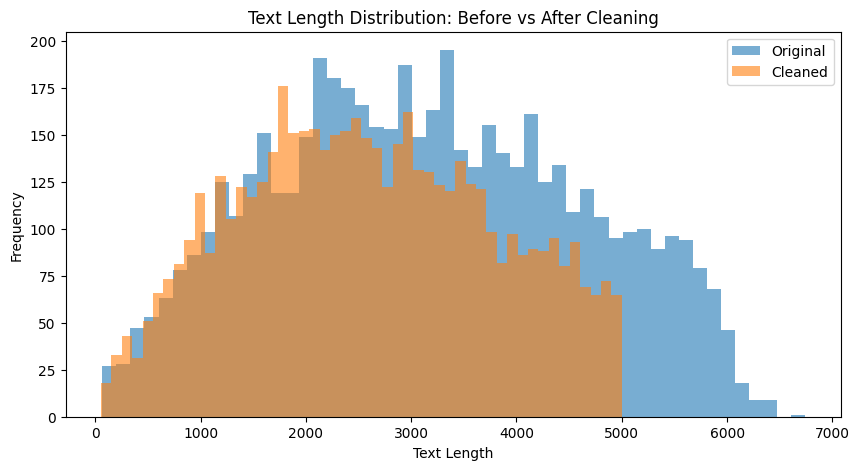

In [ ]:
# First, apply the cleaning process
job_data['description_cleaned'] = job_data['description'].apply(advanced_text_cleaning)

# Check if 'description_cleaned' exists in the DataFrame
if 'description_cleaned' in job_data.columns:
    # Text Length Filtering
    min_length, max_length = 50, 5000  # Define thresholds
    job_data = job_data[(job_data['description_cleaned'].str.len() >= min_length) &
                        (job_data['description_cleaned'].str.len() <= max_length)]

    # Plot text length distributions before and after cleaning
    plt.figure(figsize=(10, 5))
    plt.hist(job_data['description'].str.len(), bins=50, alpha=0.6, label='Original')
    plt.hist(job_data['description_cleaned'].str.len(), bins=50, alpha=0.6, label='Cleaned')
    plt.legend()
    plt.title('Text Length Distribution: Before vs After Cleaning')
    plt.xlabel('Text Length')
    plt.ylabel('Frequency')
    plt.show()
else:
    print("Error: 'description_cleaned' column not found. Check cleaning process.")


In [ ]:
# Check the cleaned data
print(job_data.head())

            job_id                             company_name  \
73989   3902944011                            Current Power   
59308   3901960222                             DISH Network   
44663   3900944095  Coca-Cola Bottling Company UNITED, Inc.   
81954   3903878594                        Denver7 (KMGH-TV)   
113151  3905670593                  BAYADA Home Health Care   

                                             title  \
73989   Senior Automation Engineer - Power Systems   
59308         DISH Installation Technician - Field   
44663                                Order Builder   
81954         Mountain Multimedia Journalist, KMGH   
113151              Licensed Practical Nurse (LPN)   

                                              description  max_salary  \
73989   The Senior Automation / Power Systems Engineer...         NaN   
59308   Company Summary\n\nDISH, an EchoStar Company, ...       19.75   
44663   Division: North Alabama\n\nDepartment : Oxford...         NaN   
8195

In [ ]:
# Check for missing values after preprocessing
print(job_data.isnull().sum())

job_id                                                            0
company_name                                                     79
title                                                             0
description                                                       0
max_salary                                                     4131
pay_period                                                     3852
location                                                          0
company_id                                                       79
views                                                            86
med_salary                                                     5074
min_salary                                                     4131
formatted_work_type                                               0
applies                                                        4343
original_listed_time                                              0
remote_allowed                                  

In [ ]:
# Check for missing values across all columns
missing_values = job_data.isnull().sum()
missing_percentage = (missing_values / len(job_data)) * 100
missing_info = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
print("Missing Values Analysis:")
print(missing_info)

# Document and handle missing values
categorical_cols = job_data.select_dtypes(include=['object']).columns
numerical_cols = job_data.select_dtypes(include=['number']).columns

for col in categorical_cols:
    if missing_values[col] > 0:
        job_data[col].fillna('Unknown', inplace=True)
        print(f"Filled missing values in {col} with 'Unknown'.")

for col in numerical_cols:
    if missing_values[col] > 0:
        median_value = job_data[col].median()
        job_data[col].fillna(median_value, inplace=True)
        print(f"Filled missing values in {col} with median value: {median_value}.")


Missing Values Analysis:
                                                    Missing Values  Percentage
job_id                                                           0    0.000000
company_name                                                    79    1.475808
title                                                            0    0.000000
description                                                      0    0.000000
max_salary                                                    4131   77.171679
pay_period                                                    3852   71.959649
location                                                         0    0.000000
company_id                                                      79    1.475808
views                                                           86    1.606576
med_salary                                                    5074   94.787969
min_salary                                                    4131   77.171679
formatted_work_type        

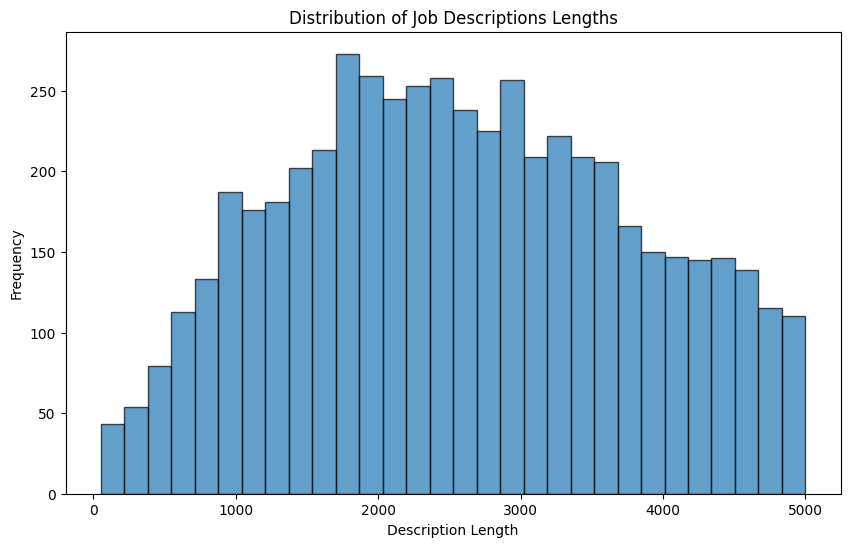

In [ ]:
# Add a new column for job description length if not already present
if 'description_cleaned' in job_data.columns:
    job_data['description_length'] = job_data['description_cleaned'].apply(len)

# Plot the distribution of job descriptions' lengths
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(job_data['description_length'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Job Descriptions Lengths')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.show()


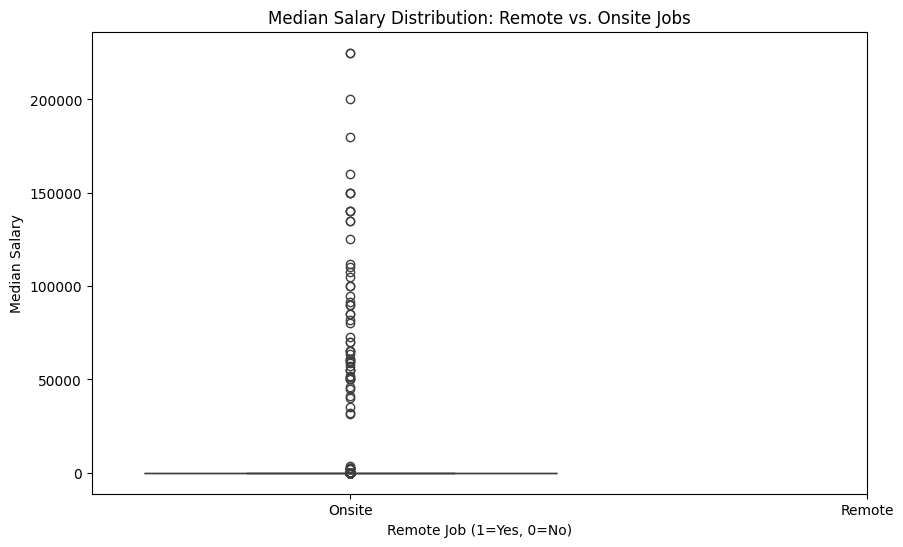

In [ ]:
# Check if 'remote_flag' and 'med_salary' exist; otherwise, preprocess them
if 'remote_flag' not in job_data.columns:
    job_data['remote_flag'] = job_data['remote_allowed'].apply(lambda x: 1 if x.lower() == 'yes' else 0)

if 'med_salary' in job_data.columns:

    plt.figure(figsize=(10, 6))
    sns.boxplot(x=job_data['remote_flag'], y=job_data['med_salary'])
    plt.title('Median Salary Distribution: Remote vs. Onsite Jobs')
    plt.xlabel('Remote Job (1=Yes, 0=No)')
    plt.ylabel('Median Salary')
    plt.xticks([0, 1], ['Onsite', 'Remote'])
    plt.show()


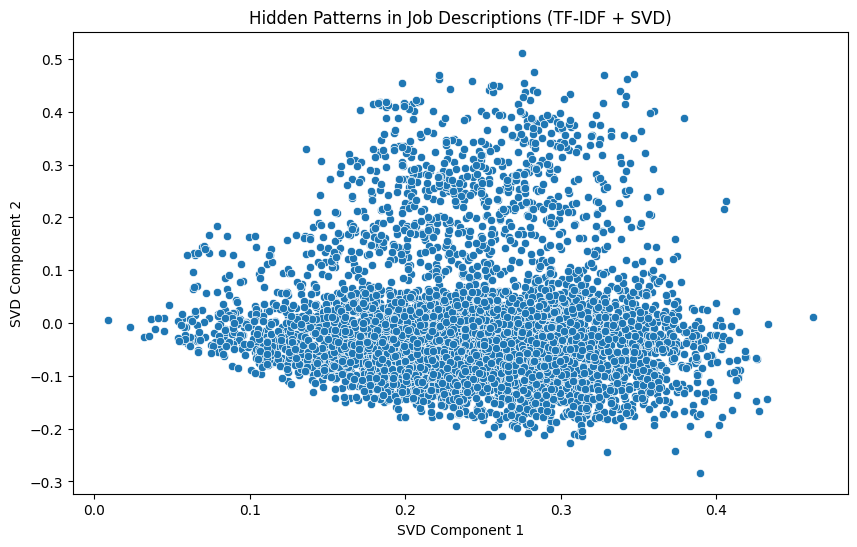

In [ ]:
# Apply TF-IDF vectorization to the cleaned descriptions
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(job_data['description_cleaned'])

# Apply TruncatedSVD for dimensionality reduction
svd = TruncatedSVD(n_components=2, random_state=42)
svd_matrix = svd.fit_transform(tfidf_matrix)

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=svd_matrix[:, 0], y=svd_matrix[:, 1])
plt.title('Hidden Patterns in Job Descriptions (TF-IDF + SVD)')
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.show()


## Data Processing

In [ ]:
# Make a copy of job_data if necessary
job_data = job_data.copy()

# Handle missing values in columns that may require more thoughtful filling
job_data['description'].fillna('No description provided', inplace=True)  # Fill NaNs with placeholder text
job_data['skills_desc'].fillna('No skills provided', inplace=True)  # Fill NaNs in skills
job_data['remote_allowed'].fillna('No', inplace=True)  # Fill missing remote status with 'No'

# Check for columns with too many missing values and decide whether to drop them
missing_data = job_data.isnull().sum() / len(job_data) * 100
columns_to_drop = missing_data[missing_data > 50].index  # Drop columns with more than 50% missing data
job_data.drop(columns=columns_to_drop, inplace=True)

# Check if 'target_class' exists before dropping rows
if 'target_class' in job_data.columns:
    job_data.dropna(subset=['target_class'], inplace=True)
else:
    print("Column 'target_class' is missing!")

# Check for missing values after preprocessing
print(job_data.isnull().sum())


Column 'target_class' is missing!
job_id                                                         0
company_name                                                   0
title                                                          0
description                                                    0
max_salary                                                     0
pay_period                                                     0
location                                                       0
company_id                                                     0
views                                                          0
med_salary                                                     0
min_salary                                                     0
formatted_work_type                                            0
applies                                                        0
original_listed_time                                           0
remote_allowed                                          

In [ ]:
# Define custom stopwords and regular expressions for cleaning
custom_stopwords = set(stopwords.words('english') + ['experience', 'required', 'skills', 'job', 'work'])

# Function to clean text
def advanced_text_cleaning(text):
    if len(text) < 50:  # Skip short descriptions
        return ''

    # Handle contractions (simplified version)
    contractions = {
        "I'm": "I am", "you're": "you are", "he's": "he is", "it's": "it is", "we're": "we are",
        "they're": "they are", "can't": "cannot", "won't": "will not", "'s": " is"
    }
    text = re.sub(r'\b(?:{})\b'.format('|'.join(map(re.escape, contractions.keys()))),
                  lambda match: contractions[match.group(0)], text)

    # Tokenize and clean text (converts text to lowercase and removes stopwords)
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word not in custom_stopwords]  # Remove stopwords

    return ' '.join(tokens)


# Apply cleaning to the 'description' and 'skills_desc' columns
job_data['description_cleaned'] = job_data['description'].apply(advanced_text_cleaning)
job_data['skills_desc_cleaned'] = job_data['skills_desc'].apply(advanced_text_cleaning)


In [ ]:
# Additional normalization steps (if required)
def normalize_text(text):
    # Remove non-alphanumeric characters (keeping spaces)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)

    # Normalize spaces (remove extra spaces)
    text = ' '.join(text.split())

    return text

# Apply text normalization to cleaned columns
job_data['description_cleaned'] = job_data['description_cleaned'].apply(normalize_text)
job_data['skills_desc_cleaned'] = job_data['skills_desc_cleaned'].apply(normalize_text)


In [ ]:
# Apply Z-score method for outlier detection
job_data['job_length_zscore'] = zscore(job_data['job_length'])
job_data = job_data[job_data['job_length_zscore'].abs() <= 3]  # Keep only rows within 3 standard deviations


In [ ]:
# Perform cleaning directly without redundant checks
job_data['description_cleaned'] = job_data['description'].str.lower()  # Convert to lowercase
job_data['description_cleaned'] = job_data['description_cleaned'].str.replace(r'[^a-z\s]', '', regex=True)  # Remove non-alphanumeric
job_data['description_cleaned'] = job_data['description_cleaned'].str.replace(r'\s+', ' ', regex=True).str.strip()  # Normalize spaces

print("Data cleaning process completed. 'description_cleaned' column created.")


Data cleaning process completed. 'description_cleaned' column created.


In [ ]:
# Extract key skills using TF-IDF Vectorizer
skill_vectorizer = TfidfVectorizer(stop_words='english', max_features=50)  # Adjust max_features for number of skills
skill_tfidf_matrix = skill_vectorizer.fit_transform(job_data['description_cleaned'])

# Create a DataFrame with top skills
skill_features = pd.DataFrame(skill_tfidf_matrix.toarray(), columns=skill_vectorizer.get_feature_names_out())

# Append the skill features to the original DataFrame
job_data = pd.concat([job_data, skill_features], axis=1)
print(f"TF-IDF features for top skills added to the dataset. {skill_features.shape[1]} skills extracted.")


TF-IDF features for top skills added to the dataset. 50 skills extracted.


In [ ]:
# Analyze and remove rare skills
rare_skills_threshold = skill_features.sum().quantile(0.05)  # Use 5th percentile as cutoff
rare_skills = skill_features.columns[skill_features.sum() < rare_skills_threshold]

# Drop rare skills from the dataset
job_data.drop(columns=rare_skills, inplace=True)
print(f"Rare skills removed from the dataset. {len(rare_skills)} columns dropped.")


Rare skills removed from the dataset. 3 columns dropped.


In [ ]:
# Ensure 'description_cleaned' column has no NaN values
job_data['description_cleaned'] = job_data['description_cleaned'].fillna('')

# Feature extraction from job description text
job_data['job_length'] = job_data['description_cleaned'].apply(len)  # Length of the job description

# Ensure 'skills_desc_cleaned' column has no NaN values
job_data['skills_desc_cleaned'] = job_data['skills_desc_cleaned'].fillna('')

job_data['num_skills'] = job_data['skills_desc_cleaned'].apply(lambda x: len(x.split(',')))  # Number of skills listed

# Dynamically extract top 10 skills based on frequency
top_skills = skill_features.sum().sort_values(ascending=False).head(10).index.tolist()

# Create binary features for dynamically identified top skills
for skill in top_skills:
    job_data[f'skill_{skill}'] = job_data['skills_desc_cleaned'].apply(lambda x: 1 if skill in x else 0)

# Check the feature engineering results
print(job_data[['job_length', 'num_skills'] + [f'skill_{skill}' for skill in top_skills]].head())


        job_length  num_skills  skill_experience  skill_work  skill_team  \
73989         4454           1                 0           0           0   
59308         2870           1                 0           0           0   
44663         3153           1                 0           0           0   
81954         5260           1                 0           0           0   
113151        1930           1                 0           0           0   

        skill_job  skill_skills  skill_care  skill_business  skill_management  \
73989           0             0           0               0                 0   
59308           0             0           0               0                 0   
44663           0             0           0               0                 0   
81954           0             0           0               0                 0   
113151          0             0           0               0                 0   

        skill_sales  skill_including  
73989            

In [ ]:
# Feature scaling
scaler = StandardScaler()

# Scale features that are numerical
job_data[['job_length', 'num_skills']] = scaler.fit_transform(job_data[['job_length', 'num_skills']])


In [ ]:
# Check for missing values after preprocessing
print(job_data.isnull().sum())

job_id              5102
company_name        5102
title               5102
description         5102
max_salary          5102
                    ... 
skill_care             0
skill_business         0
skill_management       0
skill_sales            0
skill_including        0
Length: 105, dtype: int64


In [ ]:
# Inspect the first few rows of the cleaned data
print(job_data.head())


              job_id                             company_name  \
73989   3.902944e+09                            Current Power   
59308   3.901960e+09                             DISH Network   
44663   3.900944e+09  Coca-Cola Bottling Company UNITED, Inc.   
81954   3.903879e+09                        Denver7 (KMGH-TV)   
113151  3.905671e+09                  BAYADA Home Health Care   

                                             title  \
73989   Senior Automation Engineer - Power Systems   
59308         DISH Installation Technician - Field   
44663                                Order Builder   
81954         Mountain Multimedia Journalist, KMGH   
113151              Licensed Practical Nurse (LPN)   

                                              description  max_salary  \
73989   The Senior Automation / Power Systems Engineer...    72650.00   
59308   Company Summary\n\nDISH, an EchoStar Company, ...       19.75   
44663   Division: North Alabama\n\nDepartment : Oxford...    7265

## Feature Engineering

In [ ]:
!pip install umap-learn

In [ ]:
# Ensure cleaned descriptions are processed
job_data['description_cleaned'] = job_data['description_cleaned'].fillna('')

# TF-IDF with Multi-grams (unigrams, bigrams, and trigrams)
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 3),  # Unigrams, bigrams, and trigrams
    stop_words='english',  # Remove common stopwords
    max_features=5000  # Limit to top 5000 features
)
X_tfidf = tfidf_vectorizer.fit_transform(job_data['description_cleaned'])

# Extract the top 20 most frequent skills
top_skills = tfidf_vectorizer.get_feature_names_out()[:20]

# Create binary features for dynamically identified top skills
for skill in top_skills:
    job_data[f'skill_{skill}'] = job_data['description_cleaned'].apply(lambda x: 1 if skill in x else 0)

# Add TF-IDF matrix as a DataFrame
tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
job_data = pd.concat([job_data, tfidf_df], axis=1)

print(f"Top 20 dynamically identified skills: {top_skills}")
print(job_data[[f'skill_{skill}' for skill in top_skills]].head())


Top 20 dynamically identified skills: ['abilities' 'abilities required' 'abilities required job' 'ability'
 'ability adjust' 'ability adjust focus' 'ability build'
 'ability communicate' 'ability effectively' 'ability handle'
 'ability learn' 'ability lift' 'ability make' 'ability manage'
 'ability manage multiple' 'ability meet' 'ability multitask'
 'ability obtain' 'ability perform' 'ability prioritize']
        skill_abilities  skill_abilities required  \
73989               0.0                       0.0   
59308               0.0                       0.0   
44663               0.0                       0.0   
81954               1.0                       0.0   
113151              0.0                       0.0   

        skill_abilities required job  skill_ability  skill_ability adjust  \
73989                            0.0            1.0                   0.0   
59308                            0.0            1.0                   0.0   
44663                            0.0    

In [ ]:
# Ensure 'description_cleaned' column has no NaN values
job_data['description_cleaned'] = job_data['description_cleaned'].fillna('')

# Ensure all entries in 'description_cleaned' are strings
job_data['description_cleaned'] = job_data['description_cleaned'].astype(str)

# **Job Description Length and Skill Count**
# Extract additional features
job_data['job_length'] = job_data['description_cleaned'].apply(len)  # Job description length
job_data['num_skills'] = job_data['skills_desc_cleaned'].fillna('').apply(lambda x: len(x.split(',')))  # Skill count

# **Outlier Detection Using IQR**
Q1 = job_data['job_length'].quantile(0.25)
Q3 = job_data['job_length'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
job_data = job_data[(job_data['job_length'] >= lower_bound) & (job_data['job_length'] <= upper_bound)]
print(f"Rows after removing outliers: {len(job_data)}")


Rows after removing outliers: 14914


In [ ]:
# **Generate BERT Embeddings**
model = SentenceTransformer('all-MiniLM-L6-v2')

job_data['bert_embeddings'] = job_data['description_cleaned'].apply(
    lambda x: model.encode(x) if isinstance(x, str) else np.zeros(model.get_sentence_embedding_dimension())
)

# Convert embeddings into a numpy array
bert_embeddings = np.vstack(job_data['bert_embeddings'].values)
print(f"Shape of the embeddings: {bert_embeddings.shape}")


Shape of the embeddings: (14914, 384)


In [ ]:
job_data['bert_embeddings'] = job_data['description_cleaned'].apply(
    lambda x: model.encode(x) if isinstance(x, str) else np.zeros(model.get_sentence_embedding_dimension())
)
bert_embeddings = np.vstack(job_data['bert_embeddings'].values)
print(f"Shape of the embeddings: {bert_embeddings.shape}")

Shape of the embeddings: (14914, 384)


In [ ]:
# Clustering on BERT Embeddings
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
job_data['cluster'] = dbscan.fit_predict(bert_embeddings)

print(f"Cluster distribution: {job_data['cluster'].value_counts()}")

Cluster distribution: cluster
 1    9968
 0    4928
-1      18
Name: count, dtype: int64


In [ ]:
# Filter job_data to match rows used in X_tfidf
job_data_filtered = job_data[job_data['description_cleaned'].notnull()].reset_index(drop=True)

# Verify the row counts match before proceeding
if X_tfidf.shape[0] != len(job_data_filtered):
    print(f"Mismatch detected: Rows in X_tfidf ({X_tfidf.shape[0]}) != Rows in job_data_filtered ({len(job_data_filtered)})")
    job_data_filtered = job_data_filtered.iloc[:X_tfidf.shape[0]].reset_index(drop=True)

# Fit LDA for topic modeling
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda_topics = lda.fit_transform(X_tfidf)

# Verify shapes of lda_topics and job_data_filtered
print(f"Rows in lda_topics: {lda_topics.shape[0]}")
print(f"Rows in job_data_filtered: {len(job_data_filtered)}")

# Add topic probabilities to the dataset
for i in range(lda.components_.shape[0]):
    job_data_filtered[f'topic_{i}'] = lda_topics[:, i]

# Display results
print(job_data_filtered[['title'] + [f'topic_{i}' for i in range(5)]].head())


Mismatch detected: Rows in X_tfidf (10455) != Rows in job_data_filtered (14914)
Rows in lda_topics: 10455
Rows in job_data_filtered: 10455
                                        title  title   topic_0   topic_1  \
0  Senior Automation Engineer - Power Systems    NaN  0.434004  0.521512   
1        DISH Installation Technician - Field    NaN  0.281594  0.015714   
2                               Order Builder    NaN  0.739566  0.014283   
3              Licensed Practical Nurse (LPN)    NaN  0.012421  0.012377   
4             Human Resources Project Manager    NaN  0.018191  0.018173   

    topic_2   topic_3   topic_4  
0  0.014981  0.014721  0.014781  
1  0.671727  0.015402  0.015563  
2  0.217893  0.014064  0.014193  
3  0.951015  0.012043  0.012144  
4  0.670063  0.018040  0.275532  


## Modelling

In [ ]:
# Fill NaN values in 'skills_desc' column with empty strings
job_data['skills_desc'].fillna('', inplace=True)

# Ensure all entries in 'skills_desc' are strings
job_data['skills_desc'] = job_data['skills_desc'].astype(str)

# Convert 'skills_desc' to a list of skills (multi-label format)
job_data['skills_list'] = job_data['skills_desc'].str.split(',')

In [ ]:
# Use MultiLabelBinarizer to convert the multi-label data into a binary matrix
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(job_data['skills_list'])

# TF-IDF Vectorization for the 'description_cleaned' column
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
X = tfidf.fit_transform(job_data['description_cleaned'])


In [ ]:
# Clustering Validation (if clusters exist)

if 'cluster' in job_data.columns and len(set(job_data['cluster'])) > 1:
    silhouette_avg = silhouette_score(X, job_data['cluster'], metric='cosine')
    davies_bouldin_avg = davies_bouldin_score(X.toarray(), job_data['cluster'])
    print(f"Silhouette Score: {silhouette_avg}")
    print(f"Davies-Bouldin Index: {davies_bouldin_avg}")
else:
    print("Clustering validation skipped (no valid clusters).")

Silhouette Score: 0.009796018763825595
Davies-Bouldin Index: 6.022621394896913


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the OneVsRestClassifier with a Random Forest classifier
classifier = OneVsRestClassifier(RandomForestClassifier(random_state=42))

# Train the classifier
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

In [ ]:

# Evaluate the model using F1 score, precision, and recall (weighted)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"F1 Score (Weighted): {f1}")
print(f"Precision (Weighted): {precision}")
print(f"Recall (Weighted): {recall}")

F1 Score (Weighted): 0.9844115768956136
Precision (Weighted): 0.9821054465772666
Recall (Weighted): 0.986728599867286


In [ ]:
# Test different topic numbers
best_n_topics = None
best_perplexity = float('inf')
for n_topics in range(2, 11):  # Test topics from 2 to 10
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)  # Use the TF-IDF matrix
    perplexity = lda.perplexity(X)
    print(f"Topics: {n_topics}, Perplexity: {perplexity}")
    if perplexity < best_perplexity:
        best_n_topics = n_topics
        best_perplexity = perplexity


Topics: 2, Perplexity: 3536.55983076657
Topics: 3, Perplexity: 3980.6295130422227
Topics: 4, Perplexity: 4231.296272300066
Topics: 5, Perplexity: 4528.726740404564
Topics: 6, Perplexity: 4726.437089054612
Topics: 7, Perplexity: 4859.653742915152
Topics: 8, Perplexity: 4932.528380809664
Topics: 9, Perplexity: 5109.706004786047
Topics: 10, Perplexity: 5223.336222328505


In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Use the best number of topics
print(f"Selected Number of Topics: {best_n_topics}")
lda = LatentDirichletAllocation(n_components=best_n_topics, random_state=42)
lda_features = lda.fit_transform(X)

# Combine TF-IDF and LDA features
X = np.hstack((X.toarray(), lda_features))

# Train and evaluate multiple models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
}

Selected Number of Topics: 2


In [ ]:
#Evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    classifier = OneVsRestClassifier(model)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"F1 Score (Weighted): {f1}")
    print(f"Precision (Weighted): {precision}")
    print(f"Recall (Weighted): {recall}")


Training Random Forest...
F1 Score (Weighted): 0.9844115768956136
Precision (Weighted): 0.9821054465772666
Recall (Weighted): 0.986728599867286

Training Logistic Regression...
F1 Score (Weighted): 0.9802688624544458
Precision (Weighted): 0.9771469870963105
Recall (Weighted): 0.9834107498341075

Training Gradient Boosting...
F1 Score (Weighted): 0.9813586624837436
Precision (Weighted): 0.982405969751351
Recall (Weighted): 0.9804246848042468


In [ ]:
# Get predicted probabilities for the test set
y_pred_proba = classifier.predict_proba(X_test)

# Map test indices back to original job_data indices
_, test_indices = train_test_split(job_data.index, test_size=0.2, random_state=42)

# Cluster-based skill recommendations (if clusters are available)
cluster_skill_ranking = {}
if 'cluster' in job_data.columns:
    for cluster_id in set(job_data['cluster']):
        # Get indices for the current cluster that are also in the test set
        cluster_indices = test_indices[job_data.loc[test_indices, 'cluster'] == cluster_id]

        # Ensure there are test samples in this cluster
        if len(cluster_indices) == 0:
            continue

        # Get probabilities for the test samples in this cluster
        cluster_probs = y_pred_proba[[i for i, idx in enumerate(test_indices) if idx in cluster_indices]]

        for idx, probs in zip(cluster_indices, cluster_probs):
            top_skills_idx = np.argsort(probs)[-5:][::-1]
            top_skills = [mlb.classes_[i] for i in top_skills_idx]
            cluster_skill_ranking[f"Cluster {cluster_id}, Test Job {idx+1}"] = top_skills

# Uncomment the following if you want to debug or check the results
# print("\nCluster-Specific Skill Recommendations:")
# for key, skills in cluster_skill_ranking.items():
#     print(f"{key}: {skills}")

# Standard skill recommendations
skill_ranking = {}
for idx, probs in enumerate(y_pred_proba):
    top_skills_idx = np.argsort(probs)[-5:][::-1]
    top_skills = [mlb.classes_[i] for i in top_skills_idx]
    skill_ranking[f"Test Job {idx+1}"] = top_skills

# Uncomment the following if you want to debug or check the results
# print("\nSkill Recommendations for Test Data:")
# print(skill_ranking)


In [ ]:
import pickle

# Save TF-IDF vectorizer
with open("tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf, f)

# Save trained classifier
with open("trained_classifier.pkl", "wb") as f:
    pickle.dump(classifier, f)

# Save MultiLabelBinarizer
with open("mlb.pkl", "wb") as f:
    pickle.dump(mlb, f)

print("Models and vectorizers saved successfully.")


Models and vectorizers saved successfully.


## Model Evaluation

In [ ]:
# Convert y_test and y_pred to binary indicator matrices
y_test_bin = label_binarize(y_test, classes=mlb.classes_)
y_pred_bin = label_binarize(y_pred, classes=mlb.classes_)

# Create the plot
plt.figure(figsize=(10, 6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

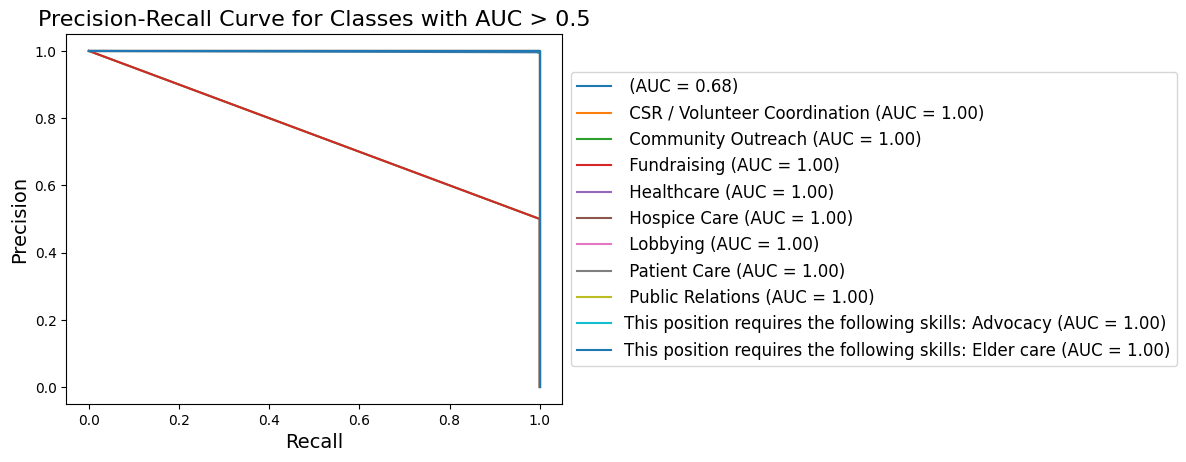

In [ ]:
# Counter for skipped labels
skipped_labels = []

# Loop through each class and plot the Precision-Recall curve for classes with AUC > 0.5
for i in range(y_test_bin.shape[1]):
    # Skip labels where only one class is present in y_test
    if len(np.unique(y_test_bin[:, i])) == 1:
        skipped_labels.append(mlb.classes_[i])
        continue

    # Calculate precision, recall, and AUC
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_bin[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_pred_bin[:, i])

    # Only plot classes with AUC > 0.5
    if auc > 0.5:
        plt.plot(recall, precision, label=f'{mlb.classes_[i]} (AUC = {auc:.2f})')

# Add plot title and labels
plt.title('Precision-Recall Curve for Classes with AUC > 0.5', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)

# Adjust legend placement to avoid overlapping
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, ncol=1, frameon=True)

# Show the plot with tight layout
plt.tight_layout()
plt.show()

In [ ]:
# Summarize skipped labels
if skipped_labels:
    print(f"\nSkipped {len(skipped_labels)} labels with only one class in y_test.")


Skipped 283 labels with only one class in y_test.


In [ ]:
# Get the predicted probabilities for the test set
y_pred_proba = classifier.predict_proba(X_test)

# Initialize a dictionary to store top skills for each job
skill_ranking = {}

# Filter out invalid skills (e.g., placeholders like "PI...")
def is_valid_skill(skill):
    return skill.strip() and not skill.startswith("PI") and len(skill.split()) <= 5

# Loop through each test instance and store the top 5 valid skills
for idx in range(min(10, X_test.shape[0])):  # Limit to first 10 jobs for demonstration
    probs = y_pred_proba[idx]
    top_skills_idx = np.argsort(probs)[-5:][::-1]  # Get top 5 indices by probability
    top_skills = [mlb.classes_[i].strip() for i in top_skills_idx if is_valid_skill(mlb.classes_[i])]

    # Only include non-empty valid skills
    if top_skills:
        skill_ranking[f"Job {idx+1}"] = top_skills

In [ ]:
# Print concise skill recommendations
print("Skill Recommendations for Test Data (First 10 Jobs):")
if skill_ranking:
    for job, skills in skill_ranking.items():
        print(f"{job}: {', '.join(skills)}")
else:
    print("No valid skill recommendations available.")

Skill Recommendations for Test Data (First 10 Jobs):
Job 1: Fundraising, Community Outreach, People Skills
Job 2: Fundraising, Community Outreach, People Skills
Job 3: Fundraising, Community Outreach, People Skills
Job 4: Fundraising, Community Outreach, People Skills
Job 5: Fundraising, Community Outreach, People Skills
Job 6: Fundraising, Community Outreach, People Skills
Job 7: Fundraising, Community Outreach, People Skills
Job 8: Fundraising, Community Outreach, People Skills
Job 9: Fundraising, Community Outreach, People Skills
Job 10: Fundraising, Community Outreach, People Skills


In [ ]:
# Error Analysis (limited to first 5 misclassified jobs for brevity)
misclassified_jobs = np.where((y_test != y_pred).any(axis=1))[0]
print(f"\nNumber of Misclassified Jobs: {len(misclassified_jobs)}")
print("\nError Analysis (First 5 Misclassified Jobs):")

# Track counts of predicted vs actual errors
true_none_count = 0
pred_none_count = 0


Number of Misclassified Jobs: 57

Error Analysis (First 5 Misclassified Jobs):


In [ ]:
for idx in misclassified_jobs[:5]:  # Limit to first 5 misclassified jobs
    true_skills = [skill.strip() for skill in mlb.inverse_transform(y_test[idx:idx+1])[0] if is_valid_skill(skill)]
    predicted_skills = [skill.strip() for skill in mlb.inverse_transform(y_pred[idx:idx+1])[0] if is_valid_skill(skill)]

    # Count jobs where true or predicted skills are None
    if not true_skills:
        true_none_count += 1
    if not predicted_skills:
        pred_none_count += 1

    print(f"Job {idx+1}:")
    print(f"  True Skills: {', '.join(true_skills) if true_skills else 'None'}")
    print(f"  Predicted Skills: {', '.join(predicted_skills) if predicted_skills else 'None'}")
    print("---")

Job 126:
  True Skills: None
  Predicted Skills: Multi-Tasking, Organization, Ushering
---
Job 150:
  True Skills: Salesforce(SFDC)
  Predicted Skills: None
---
Job 155:
  True Skills: None
  Predicted Skills: Business Development & Sales Management, Customer Service, Market Research / Analysis
---
Job 227:
  True Skills: None
  Predicted Skills: 401k, Dental, Excel, Outlook, PTO, Vision, integrity, organized, retail, the communities we build
---
Job 275:
  True Skills: PI4b3e9d5325d8-29462-34015743
  Predicted Skills: None
---


In [ ]:
# Summary of errors
print("\nSummary of Errors:")
print(f"Jobs with no True Skills: {true_none_count}")
print(f"Jobs with no Predicted Skills: {pred_none_count}")


Summary of Errors:
Jobs with no True Skills: 3
Jobs with no Predicted Skills: 2
